<div style="text-align: center;">
    <a href="http://www.datascience-paris-saclay.fr">
        <img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"></a>
</div>



#  <a style="color:#920037"> DataCamp Project - Data Professional Salary Estimation </a>
###Authors: Kais Cheikh (M2DS), Bechir Trabelsi (M2DS), Karim Siala (M2DS), Nidhal Kallel (M2DS), Mohamed Mkaouer (M2DS)

#<a style="color:#920037">Introduction </a>
Data is one of the important features of every organization because it helps business leaders to make decisions based on facts, statistical numbers and trends. Due to this growing scope of data, data science came into picture. Henceforth It has become an important part of almost every sector. It provides the best solutions that help to fulfill the challenges of the ever-increasing demand and maintainable future.  As the importance of data science is increasing day by day, the need for a data scientist is also growing. Data scientist are the future of the world. Thus, a data scientist must be capable of providing great solutions which meets the challenges of all the fields. 

Considering this exponential importance of data science one might be tempted to pursue a carrier in this field, as such we can ask the very natural and straightforward question: How much do database administrators, analysts, architects, developers, and data scientists make? 

To answer this question, we introduce the following dataset in which a multitude of information is gathered from confirmed data specialists including their years of experience, their education level their skills...etc. And most importantly their salary in US dollars and given this information we would like to be able to predict the salary of an individual based on a set of skills and data he provides on himself; this will eventually help data specialists get a wider idea about their potential and be able to negotiate properly with their future employers.   

# <a style="color:#920037"> INSTALLATION OF LIBRAIRIES </a>

In [244]:
!pip install geopandas &> /dev/null

In [245]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas 
from scipy import interpolate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [246]:

df = pd.read_excel('https://query.data.world/s/yg4pp7vm5dhoj6pj4xjm43gcg73ujq',header=3)
df.drop(columns=['Timestamp','PostalCode', 'Counter', 'CompanyEmployeesOverall', 'PopulationOfLargestCityWithin20Miles'], inplace=True)
df['SalaryUSD'] = list(map(float, [str(ch).replace(" ", "").replace(",", ".") for ch in list(df.SalaryUSD)]))

## <a style="color:#920037">The features 
Our data set is composed of 6893 rows and 29 columns. These columns are: 


*   **Survey Year**: indicates the year at which the instance got taken. We have a total of 3 years (2017-2019).
*   **Timestamp**: the exacte date that the questionnary was done.
*   **SalaryUSD**: Our target, the salary of the individual.
* **County**: The Country in which the individual works.
* **PostalCode**: The postal code of the city in which the individual works.
* **PrimaryDatabase**: The main database framework used by our instances.
* **YearsWithThisDatabase**: The number of years spent using the primary database.
* **OtherDatabases**: A list containing all the data bases that he can use.
* **EmploymentStatus**: Indicate whenever an individual is a full time emplyee, a freelancer, etc.
* **JobTiTle**: It's the title of the individual. 
* **ManageStaff**: a binary feature indicating whenever our individual manage a staff or not.
* **YearsWithThisTypeOfJobs**: Indicating the number of years with that job title.
* **HowManyCompanies**: The number of companies our individual worked in.
* **OtherPeopleOnYourTeam**: The number of teammates of our individual.
* **CompanyEmployeesOverall**: The total number of employees in the company.
* **DatabaseServers**: The number of servers in the company.
* **Education**: The education level of our target.
* **EducationIsComputerRealted**: A binary feature indicates if the education of the individual is computer realted or not. 
* **Certifications**: A string indicating if the individual have certifications or not and their validity. 
* **HoursWorkedPerWeek**: The amount of hours spent working.
* **TelecommuteDaysPerWeek**: The number of days to work from home.
* **PopulationOfLargestCityWithin20Miles**: The largest nearest population.
* **EmploymentSector**: The sector of employment (private or public).
* **LookingForAnotherJob**: If the individual is looking for another job.
* **CarrerPlansThisYear**: A string, whenver the individual is searching for another job in the same company or an other one. 
* **Gender**: The gender of the individual.
* **OtherJobDuties**: The other job duties.
* **KindsOfTasksPerformed**: A list of tasks perfomed by an individual.
* **Counter**: A feature filled with the value 1. 









In [247]:
df.head(3)

,Survey Year,SalaryUSD,Country,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,ManageStaff,YearsWithThisTypeOfJob,HowManyCompanies,OtherPeopleOnYourTeam,DatabaseServers,Education,EducationIsComputerRelated,Certifications,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,LookingForAnotherJob,CareerPlansThisYear,Gender,OtherJobDuties,KindsOfTasksPerformed
0,2017,200000.0,United States,Microsoft SQL Server,10,MySQL/MariaDB,Full time employee,DBA,No,5,Not Asked,2,350,Masters,No,"Yes, and they're currently valid",45,1,Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked
1,2017,61515.0,United Kingdom,Microsoft SQL Server,15,"Oracle, PostgreSQL",Full time employee,DBA,No,3,Not Asked,1,40,None (no degree completed),NaN,"No, I never have",35,2,Private business,No,Not Asked,Not Asked,Not Asked,Not Asked
2,2017,95000.0,Germany,Microsoft SQL Server,5,"Oracle, MySQL/MariaDB, Informix",Full time employee,Other,Yes,25,Not Asked,2,100,Masters,Yes,"Yes, but they expired",45,"None, or less than 1 day per week",Private business,"Yes, but only passively (just curious)",Not Asked,Not Asked,Not Asked,Not Asked


From these 29 features we dropped these columns: 
* **Timestamp**: Same information as **SurveyYear** but with an hour precision that isn't important. 
* **PostalCode**: This feature is related to the country and takes a big number of categorical values
* **Counter**: The column itself is composed of the value 1. No information to gain. 
* **CompanyEmployeesOverall**: Doesn't add much information. 
* **PopulationOfLargestCityWithin20Miles**: This features is not useful. 



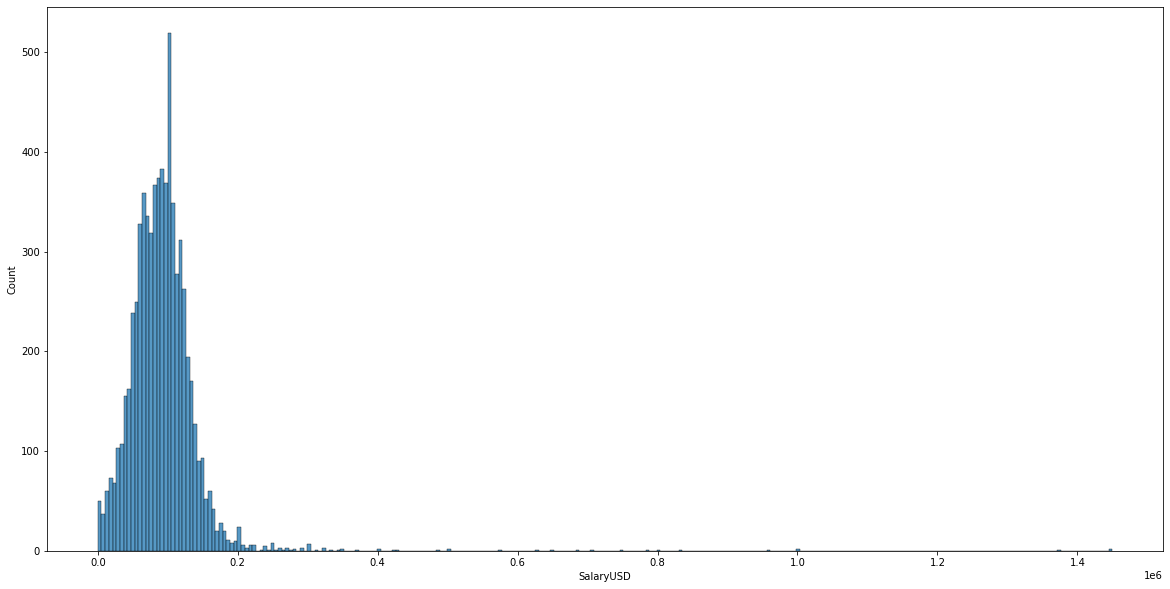

In [248]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(df.SalaryUSD)
plt.show()

## Some plots to understand our data

In [249]:
def Get_Genders(X_df):
  res = X_df[(X_df.Gender == "Male") | (X_df.Gender == "Female") | (X_df.Gender == 'Non-binary/third gender') | (X_df.Gender == 'Not Asked')] 

  res = res.replace({'Gender':{'Not Asked' : 'Other',
                      'Non-binary/third gender':'Other'}})
  res['Gender'] = OrdinalEncoder().fit_transform(res[["Gender"]])
  return res
df = Get_Genders(df)

In [250]:
df.replace({'YearsWithThisDatabase':{2000: 19,2011:8,2003:15,2004:14,2008:10}},inplace=True) #These people wrote starting year Date
df.replace({'YearsWithThisDatabase':{1050: 9,30331:2,53716:1}},inplace=True)

### Education, EducationIsComputerRelated, Certifications, HoursWorkedPerWeek

In [251]:
Counter(df.Education)

Counter({'Associates (2 years)': 753,
         'Bachelors (4 years)': 3633,
         'Doctorate/PhD': 50,
         'Masters': 1223,
         'None (no degree completed)': 1172})

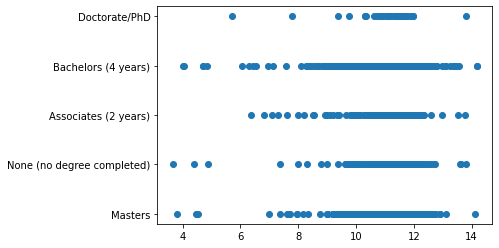

In [252]:

df = df[df["SalaryUSD"] != min(df["SalaryUSD"])] # we drop the ones who have 0 as salary
plt.plot(np.log(df["SalaryUSD"]),df["Education"],"o")
plt.show()

In [253]:
mean_salary_by_education = df[['SalaryUSD','Education']].groupby(['Education']).mean().sort_values(by = 'SalaryUSD',ascending = False)
print(mean_salary_by_education)

                                SalaryUSD
Education                                
Doctorate/PhD               102690.600000
Bachelors (4 years)          94039.850223
Masters                      93843.381509
None (no degree completed)   90953.345398
Associates (2 years)         87542.400996


What we see here is intuitively  logical because the more we study the higher our salary.

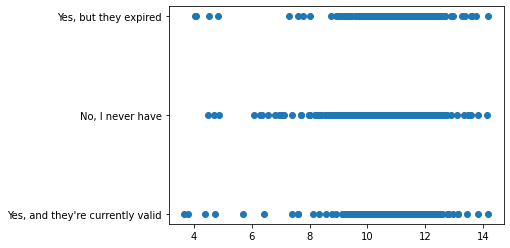

In [254]:
Counter(df.Certifications)
plt.plot(np.log(df["SalaryUSD"]),df["Certifications"],"o")
plt.show()

In [255]:
mean_salary_by_certifications = df[['SalaryUSD','Certifications']].groupby(['Certifications']).mean().sort_values(by = 'SalaryUSD',ascending = False)
print(mean_salary_by_certifications)

                                      SalaryUSD
Certifications                                 
Yes, but they expired             101787.875539
Yes, and they're currently valid   90983.498041
No, I never have                   89210.992364


We see Here that having a certification affects the salary but it does not matter if they expired or not (may be logical) because from a company's point of view expiration date of a certificate do not matter, what matters is that the skill is learned by the employee


In [256]:
print(df[['Certifications','Education']].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1))


                Certifications  Education
Certifications        1.000000   0.020641
Education             0.020641   1.000000


Here cor(Certifications ,Education) = 0.02 so the certifications has nothing to do with education

In [257]:
Counter(df.EducationIsComputerRelated)
mean_salary_by_ComputerRelated = df[['SalaryUSD','EducationIsComputerRelated']].groupby(['EducationIsComputerRelated']).mean().sort_values(by = 'SalaryUSD',ascending = False)
std_salary_by_ComputerRelated = df[['SalaryUSD','EducationIsComputerRelated']].groupby(['EducationIsComputerRelated']).std().sort_values(by = 'SalaryUSD',ascending = False)
print(mean_salary_by_ComputerRelated)
print(std_salary_by_ComputerRelated)

                               SalaryUSD
EducationIsComputerRelated              
No                          97287.331903
Yes                         91283.186890
                               SalaryUSD
EducationIsComputerRelated              
No                          65054.461401
Yes                         56252.311740


Here having a computer related education may not be the asset that will get you the highest salary (the mean salary of the ones who didn't have a computer related education is higher than the ones who did) but it is a more safe way to have a decent (normal) salary (as its variance is less than the ones who didn't)


In [258]:
print(df[['EducationIsComputerRelated','Education']].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1))

                            EducationIsComputerRelated  Education
EducationIsComputerRelated                    1.000000   0.268662
Education                                     0.268662   1.000000


education and EducationIsComputerRelated are not very correlated

In [259]:
mean_salary_by_HoursWorkedPerWeek = df[['SalaryUSD','HoursWorkedPerWeek']].groupby(['HoursWorkedPerWeek']).mean().sort_values(by = 'HoursWorkedPerWeek',ascending = True)
print(df.HoursWorkedPerWeek.mean())

43.15243813149802


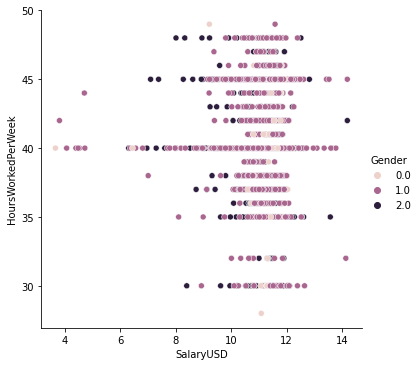

In [260]:
sns.relplot(x=np.log(df["SalaryUSD"]), y="HoursWorkedPerWeek", data=df[(df.HoursWorkedPerWeek <50) & (df.HoursWorkedPerWeek >25)], hue="Gender")
plt.show()

In [261]:
print(df[["SalaryUSD","HoursWorkedPerWeek"]].corr())

                    SalaryUSD  HoursWorkedPerWeek
SalaryUSD            1.000000            0.161131
HoursWorkedPerWeek   0.161131            1.000000


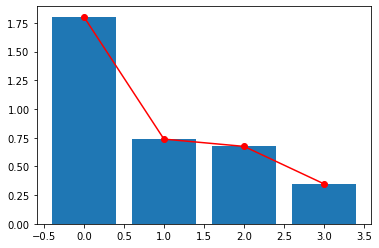

In [262]:
import warnings
warnings.filterwarnings("ignore")
ord_enc = OrdinalEncoder()
for col in ["Education", 'Certifications', 'EducationIsComputerRelated','Gender']:
  df[col] = df[col].fillna("Unkown")
  df[col] = ord_enc.fit_transform(df[[col]])

X_mkaouar = df[['Gender',"Education","HoursWorkedPerWeek", 'Certifications', 'EducationIsComputerRelated']]
y_mkaouar = df.SalaryUSD

pca = PCA(n_components=5)
pca.fit(X_mkaouar)
eigenvalues = pca.explained_variance_[1:]
plt.bar(np.arange(0,len(eigenvalues),1), eigenvalues)
plt.plot(eigenvalues, "r")
plt.plot(eigenvalues, "ro")
plt.show()


##Some Geographical plots based on countries 

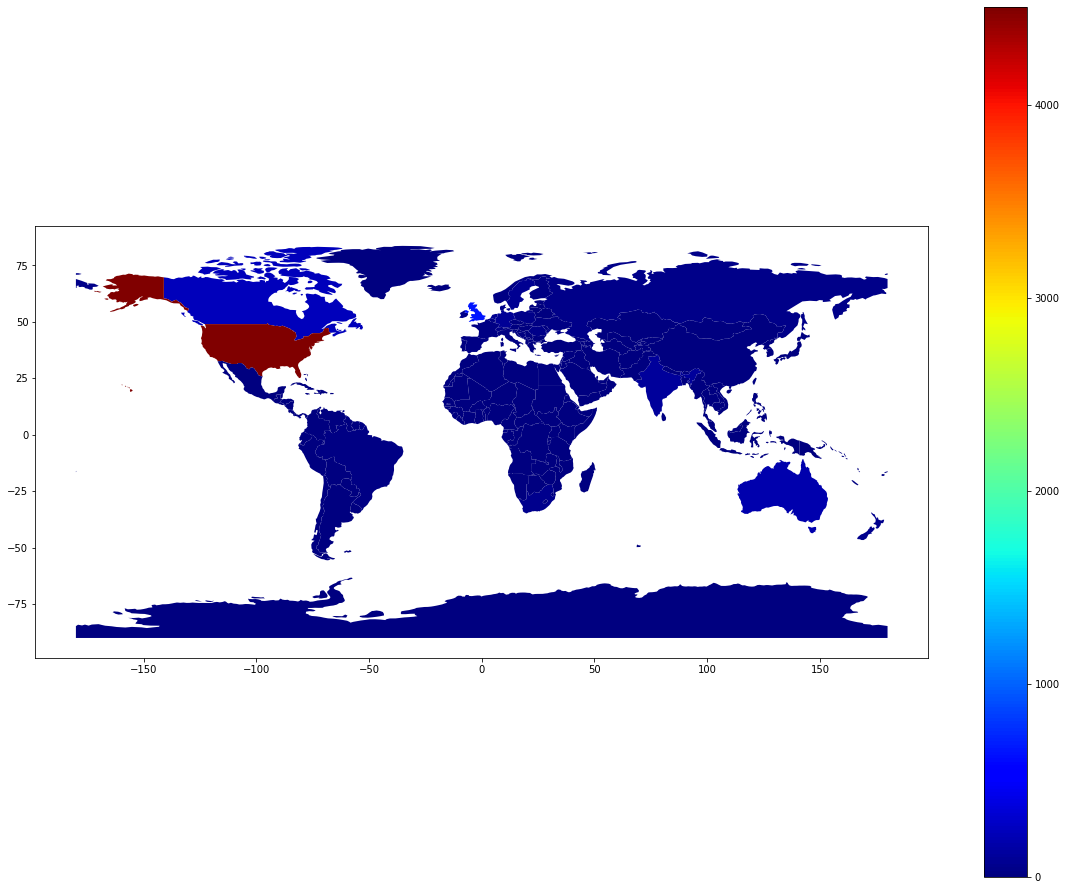

In [263]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
df = pd.read_excel('https://query.data.world/s/yg4pp7vm5dhoj6pj4xjm43gcg73ujq',header=3)
ps= df.groupby(['Country']).size()
tempdf = pd.DataFrame({'name':ps.index, 'Number_of_Data_scientists':ps.values})
tempdf= tempdf.replace({"name":{"United States":"United States of America"}})
world = world.merge(tempdf, how = 'left', on = 'name' )
world['Number_of_Data_scientists'] = world['Number_of_Data_scientists'].fillna(0)
world['salary'] = df['SalaryUSD']
world['salary'] = df['SalaryUSD'].fillna(0)
fig, ax = plt.subplots(1, 1,figsize=(20,16))
world.plot(column='Number_of_Data_scientists',ax=ax, legend=True,cmap='jet')

In the map above we can see that most of our data is from individuals living in the United States 

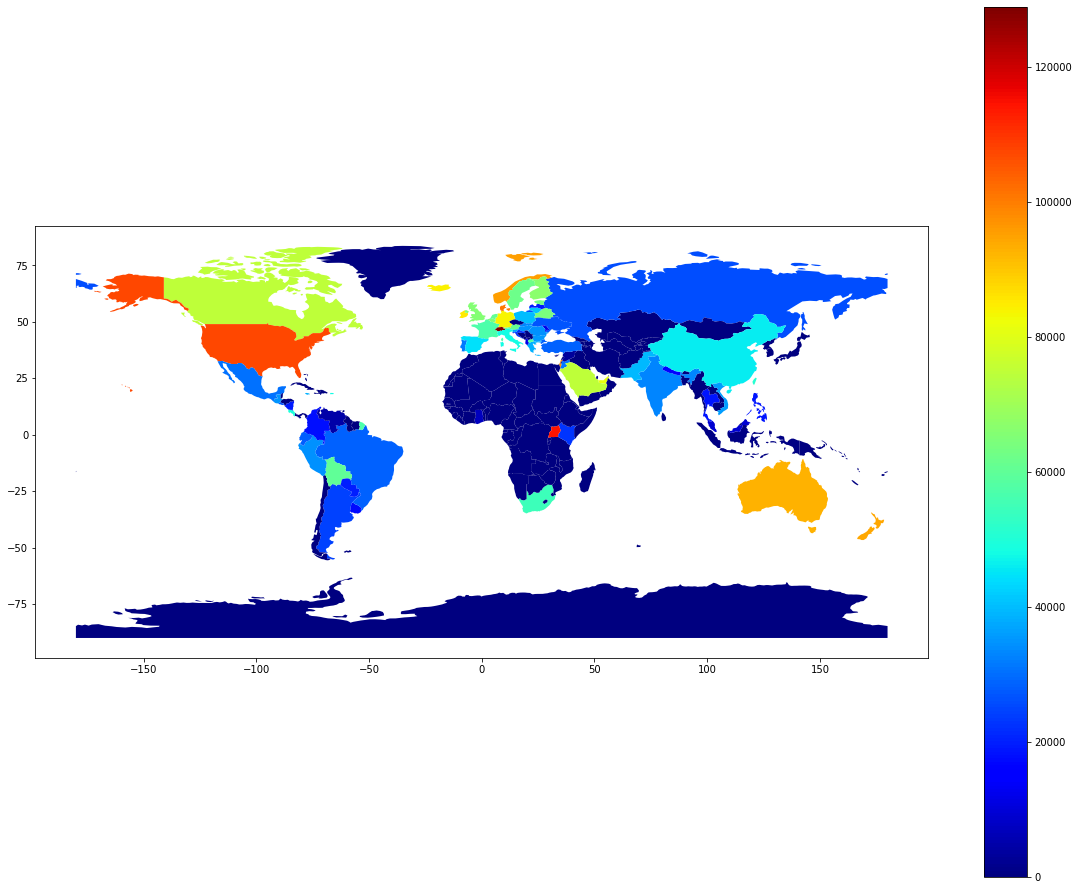

In [264]:
df['SalaryUSD'] = list(map(float, [str(ch).replace(" ", "").replace(",", ".") for ch in list(df.SalaryUSD)]))
ps= df.groupby(['Country']).mean()
ps = ps.reset_index()
tempdf= ps[['Country','SalaryUSD']]
tempdf = tempdf.rename(columns={"Country": "name"})
tempdf= tempdf.replace({"name":{"United States":"United States of America"}})
world = world.merge(tempdf, how = 'left', on = 'name' ) 
world["SalaryUSD"] = world["SalaryUSD"].fillna(0)
fig, ax = plt.subplots(1, 1,figsize=(20,16))
world.plot(column='SalaryUSD',ax=ax, legend=True,cmap='jet')

The map above shows consistant results coherent with expected revenue relative to given countries, with the exception of some unlogical outliers that must be dealt with 

###Gender distribution counter

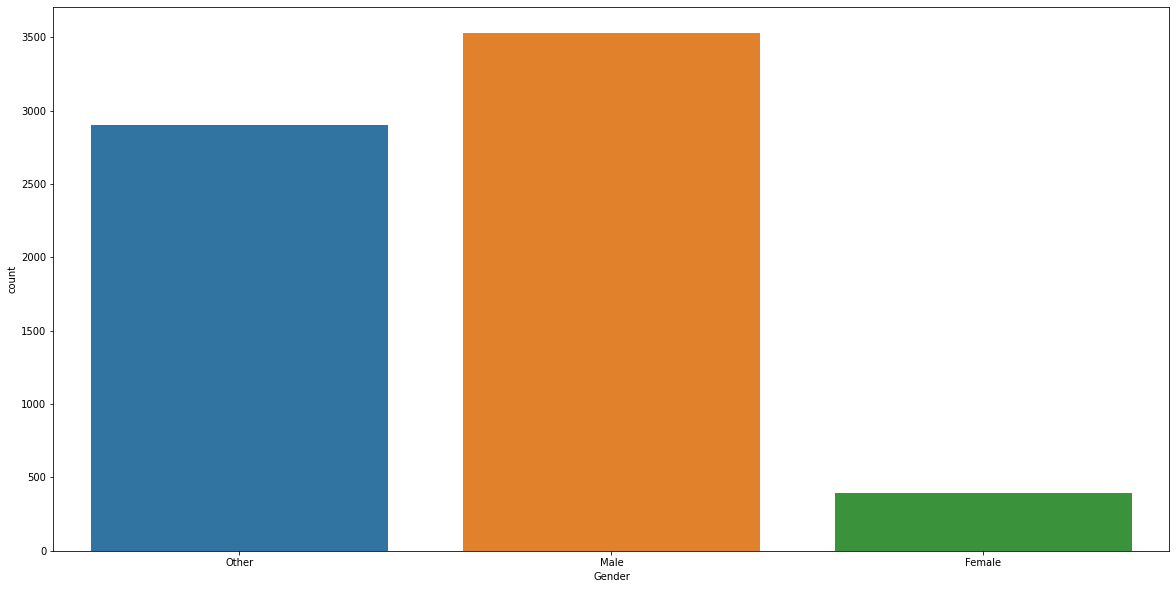

In [265]:
df = df[(df.Gender == "Male") | (df.Gender == "Female") | (df.Gender == 'Non-binary/third gender') | (df.Gender == 'Not Asked')] 

df = df.replace({'Gender':{'Not Asked' : 'Other',
                      'Non-binary/third gender':'Other'}})
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(ax = ax, x=df.loc[:,'Gender'])

###Some Salary wise plots

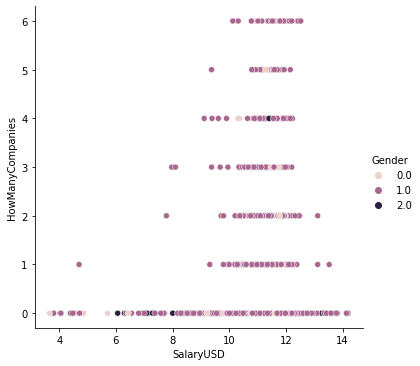

In [266]:
df['Country'] = df['Country'].fillna("Unknown")
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df["Gender"] = ord_enc.fit_transform(df[["Gender"]])
df["Country"] = ord_enc.fit_transform(df[["Country"]])
df['HowManyCompanies'] = df['HowManyCompanies'].fillna(0)
df = df.replace({'HowManyCompanies':{'Not Asked' : 0 ,
                      "1 (this is the only company where I've had this kind of position)":1,
                      '2 (I worked at another similar position elsewhere before this one)':2,
                      '6 or more':6}})
df["HowManyCompanies"] = ord_enc.fit_transform(df[["HowManyCompanies"]])
df = df.replace({"OtherPeopleOnYourTeam":{'None': 0 ,'More than 5':6} })
df['OtherPeopleOnYourTeam'] = df['OtherPeopleOnYourTeam'].fillna(0)
df["OtherPeopleOnYourTeam"] = ord_enc.fit_transform(df[["OtherPeopleOnYourTeam"]])
df = df[df["SalaryUSD"] != min(df["SalaryUSD"])] 
df['SalaryUSD'] = list(map(float, [str(ch).replace(" ", "").replace(",", ".") for ch in list(df.SalaryUSD)]))
sns.relplot(x=np.log(df["SalaryUSD"]), y="HowManyCompanies", data=df, hue="Gender")
plt.show()

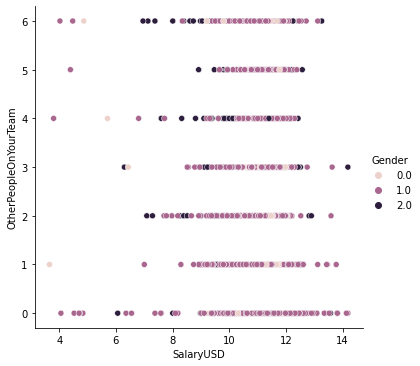

In [267]:
sns.relplot(x=np.log(df["SalaryUSD"]), y="OtherPeopleOnYourTeam", data=df, hue="Gender")
plt.show()

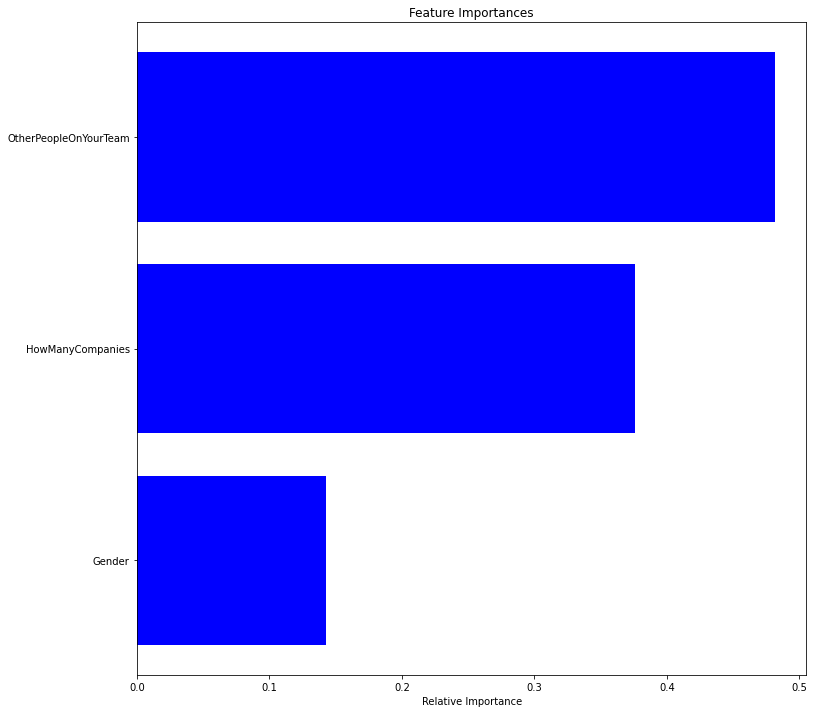

In [268]:
from sklearn.ensemble import RandomForestRegressor
X=df[['HowManyCompanies','OtherPeopleOnYourTeam','Gender']]
Y=df['SalaryUSD']
clf = RandomForestRegressor(max_depth=5, random_state=0)
clf.fit(X,Y)
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [269]:
df1 = df[['SalaryUSD', 'EmploymentSector', 'EmploymentStatus', 'ManageStaff', 'JobTitle']]
df1 = df1[df1.SalaryUSD > 0]
df2=df1
df1.head()

,SalaryUSD,EmploymentSector,EmploymentStatus,ManageStaff,JobTitle
0,200000.0,Private business,Full time employee,No,DBA
1,61515.0,Private business,Full time employee,No,DBA
2,95000.0,Private business,Full time employee,Yes,Other
3,56000.0,Private business,Full time employee,No,DBA
4,35000.0,Private business,Full time employee of a consulting/contracting...,No,DBA


Jobtitle

In [270]:
jt = Counter(df1.JobTitle)

job_dict = {}
for job, count in jt.items():
  if job == "DBA (Production Focus - build & troubleshoot servers, HA/DR)":
    job_dict[job] = "DBA 1"
  elif job == "DBA (Development Focus - tunes queries, indexes, does deployments)":
    job_dict[job] = "DBA 2"
  elif job == "DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers)":
    job_dict[job] = "DBA 3"
  elif job == "Developer: Business Intelligence (SSRS, PowerBI, etc)":
    job_dict[job] = "Developer 1"
  elif job == "Developer: App code (C#, JS, etc)":
    job_dict[job] = "Developer 2"
  elif count < 20 :
    job_dict[job] = "Other"
  else :
    job_dict[job] = job

df2.JobTitle = df1.JobTitle.apply(lambda x:job_dict[x])

df2.groupby(['JobTitle']).mean().sort_values(by = 'SalaryUSD',ascending = False)

,SalaryUSD
JobTitle,
Architect,119209.142315
Manager,115182.424165
Data Scientist,111428.321429
Engineer,99875.755853
DBA 1,94758.801007
DBA 2,94066.433465
DBA 3,93349.375181
Other,89141.723448
Developer 1,88425.186112


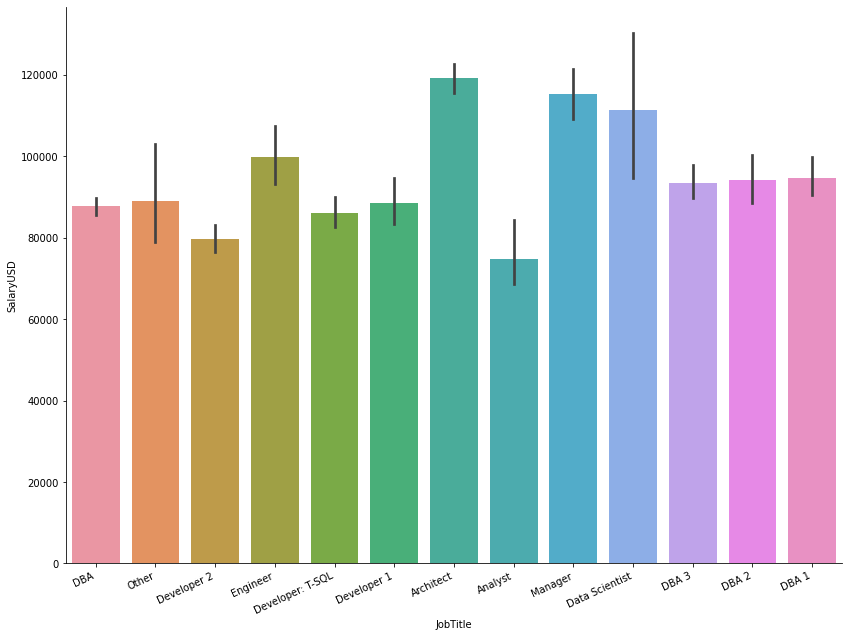

In [271]:
chart=sns.catplot(data=df2, x='JobTitle', y='SalaryUSD', kind='bar', height=8.27, aspect=11.7/8.27)
chart.set_xticklabels(rotation=25, horizontalalignment='right')

manage staff

In [272]:
oe = OrdinalEncoder()
df2["ManageStaff"] = oe.fit_transform(df1[["ManageStaff"]])
df2.groupby(['ManageStaff']).mean().sort_values(by = 'SalaryUSD',ascending = False)

,SalaryUSD
ManageStaff,
1.0,103347.701072
0.0,89649.426418


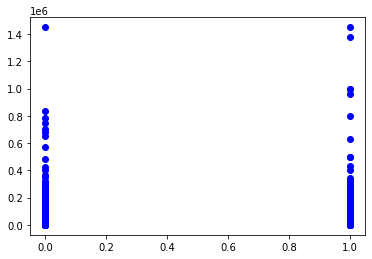

In [273]:
plt.plot(df2.ManageStaff, df2.SalaryUSD, 'bo')
plt.show()

Employment sector

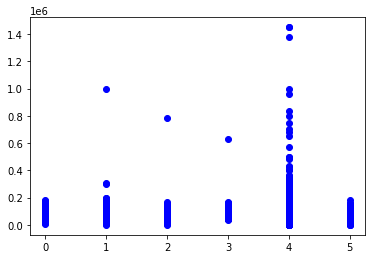

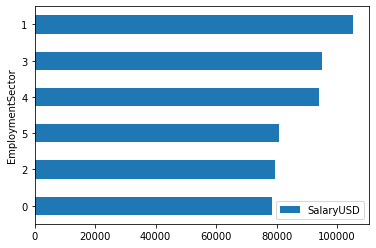

In [274]:
sector_dict={'Education (K-12, college, university)': 0,
 'Federal government': 1,
 'Local government': 2,
 'Non-profit': 3,
 'Private business': 4,
 'State/province government': 5,
 'Student': 0}
df2['EmploymentSector'] = df1.EmploymentSector.apply(lambda x:sector_dict[x])
plt.plot(df2.EmploymentSector, df1.SalaryUSD, 'bo')
plt.show()
df2.groupby(by=['EmploymentSector'])['SalaryUSD'].mean().reset_index().sort_values(['SalaryUSD'],ascending=True).plot(x='EmploymentSector',y='SalaryUSD',kind='barh')

Emp status 

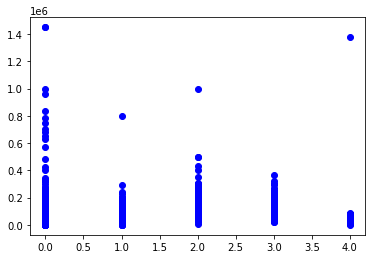

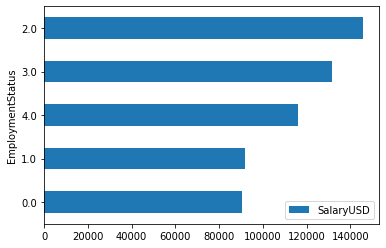

In [275]:
Counter(df1.EmploymentStatus)
df2["EmploymentStatus"] = oe.fit_transform(df1[["EmploymentStatus"]])
plt.plot(df2.EmploymentStatus, df1.SalaryUSD, 'bo')
plt.show()
df2.groupby(by=['EmploymentStatus'])['SalaryUSD'].mean().reset_index().sort_values(['SalaryUSD'],ascending=True).plot(x='EmploymentStatus',y='SalaryUSD',kind='barh')

In [276]:
def Count_(col):
  ss={}
  for g in df[col]:
    if g in ss:
      ss[g]+=1
    else:
      ss[g]=1
  return ss
  
def get_heights(col,df):
  x1=df[df[col]==1]["SalaryUSD"].mean()
  x2=df[df[col]==0]["SalaryUSD"].mean()
  heights = [x2,x1] 
  return heights

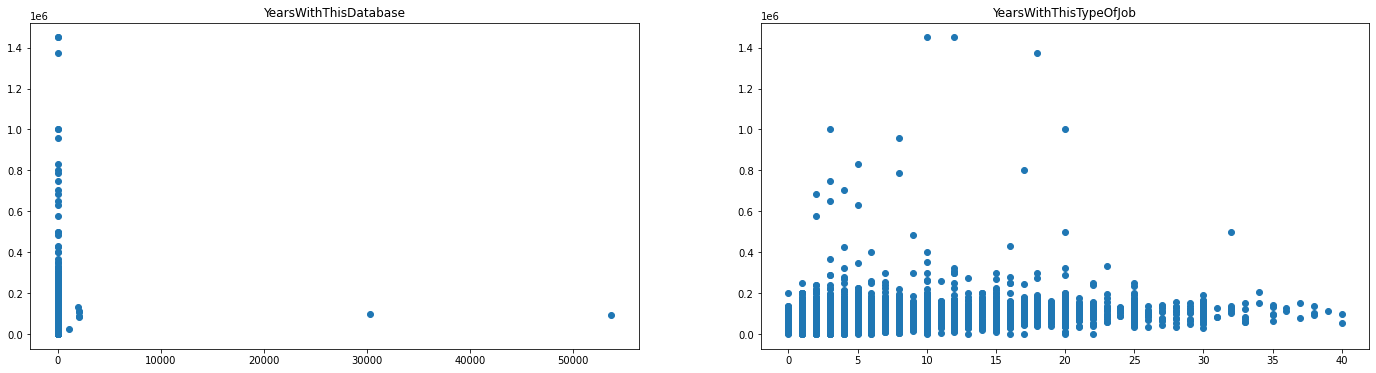

In [277]:
plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.scatter(df.YearsWithThisDatabase,df.SalaryUSD)
plt.title("YearsWithThisDatabase")

plt.subplot(1,2,2)
plt.scatter(df.YearsWithThisTypeOfJob,df.SalaryUSD)
plt.title("YearsWithThisTypeOfJob")
plt.show()

In [278]:
Count_("PrimaryDatabase")
#Not enough diversity in our dataset, even though this is normally an important feature, it is not the case for our dataset

{'Amazon RDS (any flavor)': 12,
 'Azure SQL DB': 24,
 'Cassandra': 2,
 'DB2': 16,
 'Elasticsearch': 2,
 'Microsoft Access': 15,
 'Microsoft SQL Server': 6399,
 'MongoDB': 6,
 'MySQL/MariaDB': 29,
 'Oracle': 214,
 'Other': 38,
 'PostgreSQL': 46,
 'SAP': 11,
 'SQLite': 4,
 'Teradata': 11}

In [279]:
se = Count_("OtherDatabases")
most_used_db = []
for i,j in se.items():
  if j>150:
    if type(i)==str:
      most_used_db.append(i)
new_cols={}
for i in most_used_db:
  new_cols[i]=np.zeros(df.shape[0])

for i,line in enumerate(df['OtherDatabases']):
  if type(line) is str :
    databases = line.split(', ')
    for db in databases:
      if db in new_cols:
        new_cols[db][i]=1

for i in most_used_db:
  df[i] = new_cols[i]

df['OtherDatabases'] = df['OtherDatabases'].str.split(', ').str.len()
df['OtherDatabases'].fillna(0, inplace = True)


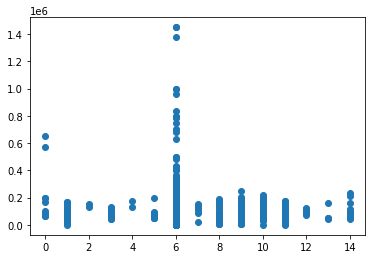

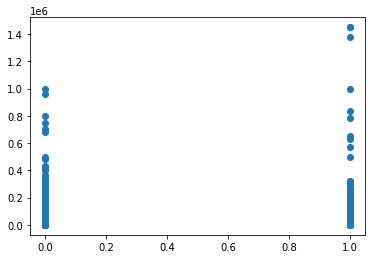

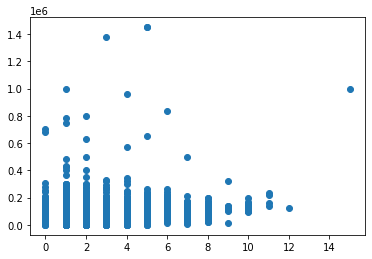

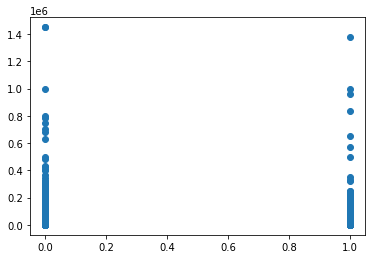

In [280]:
X = df.drop(columns=['Survey Year', 'Timestamp','Country', 'PostalCode',
       
       'EmploymentStatus', 'JobTitle', 'ManageStaff','HowManyCompanies', 'OtherPeopleOnYourTeam', 'CompanyEmployeesOverall',
       'DatabaseServers', 'Education', 'EducationIsComputerRelated',
       'Certifications', 'HoursWorkedPerWeek', 'TelecommuteDaysPerWeek',
       'PopulationOfLargestCityWithin20Miles', 'EmploymentSector',
       'LookingForAnotherJob', 'CareerPlansThisYear', 'Gender',
       'OtherJobDuties', 'KindsOfTasksPerformed', 'Counter'])
Y = X.SalaryUSD
X["PrimaryDatabase"] = X["PrimaryDatabase"].astype('category')
X["PrimaryDatabase"] = X["PrimaryDatabase"].cat.codes
X = X.drop(columns=['SalaryUSD'])

plt.scatter(X.PrimaryDatabase,Y)
plt.figure()
plt.scatter(X.Oracle,Y)
plt.figure()
plt.scatter(X["OtherDatabases"],Y)
plt.figure()
plt.scatter(X["MySQL/MariaDB"],Y)

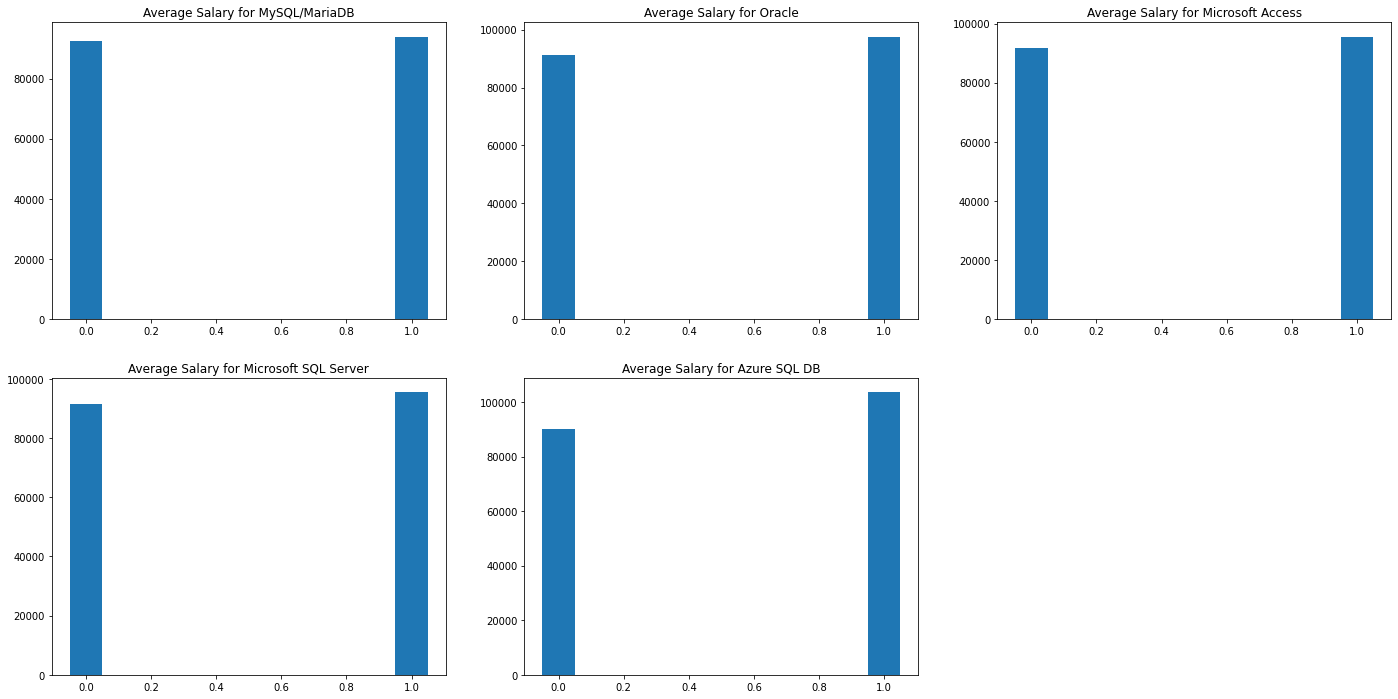

In [281]:
plt.figure(figsize=(24,12))
id=0
for col in most_used_db:
  id+=1
  plt.subplot(2,3,id)
  plt.bar(x=[0,1],height = get_heights(col,df),width=0.1)
  name = "Average Salary for "+col
  plt.title(name)

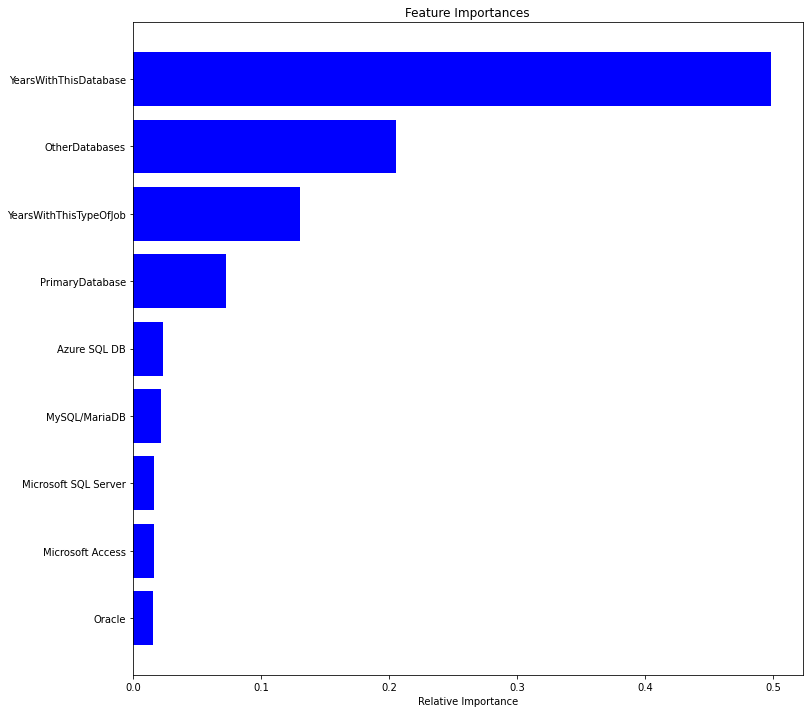

In [282]:
clf = RandomForestRegressor(max_depth=5, random_state=0)
clf.fit(X,Y)
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


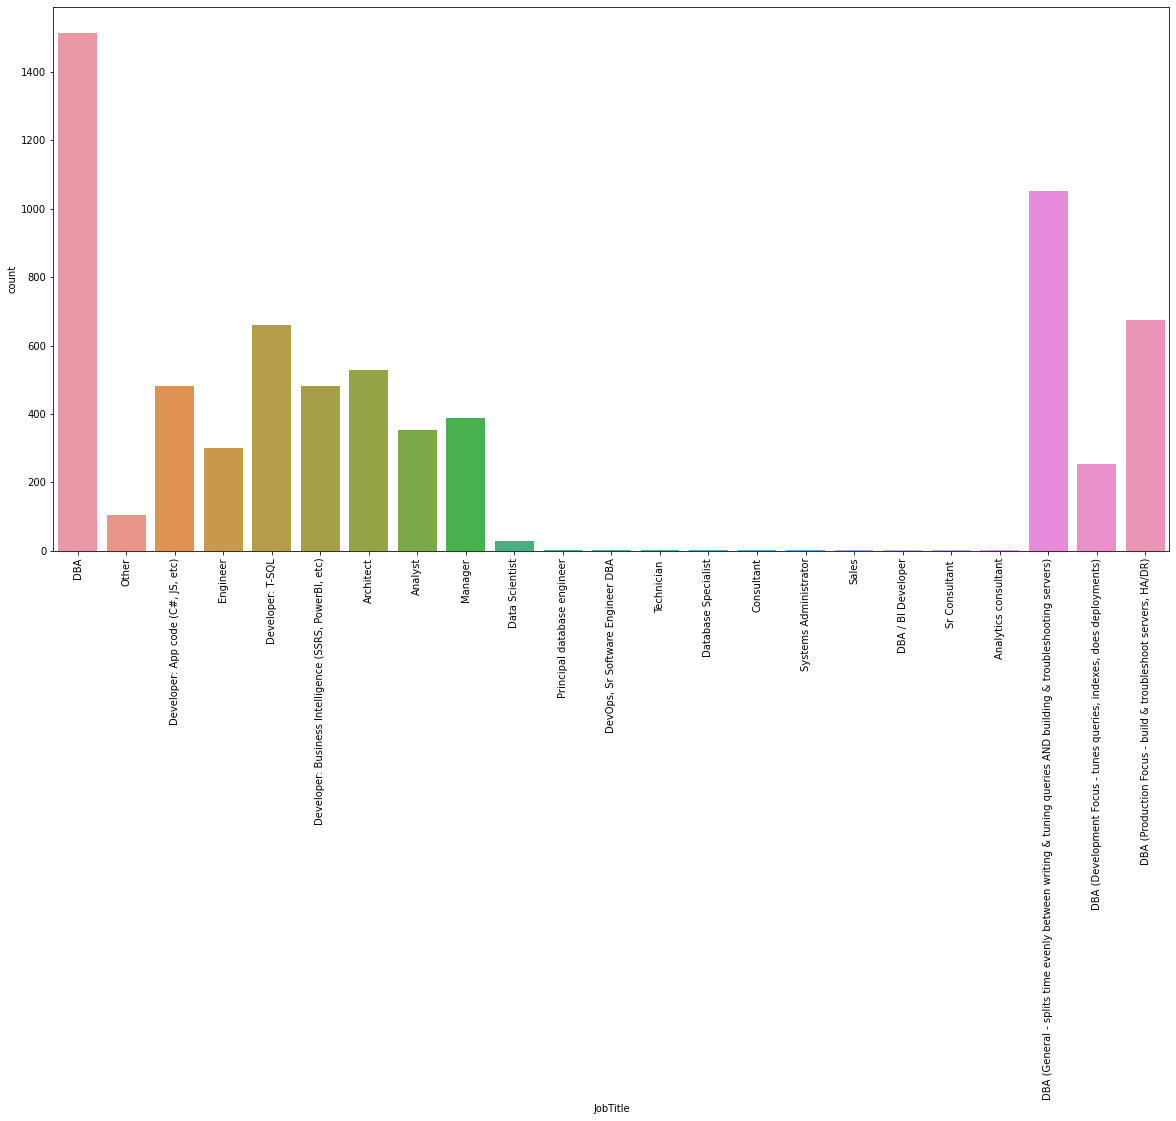

In [283]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot( x = df["JobTitle"])
plt.xticks(rotation= 90)
plt.show()

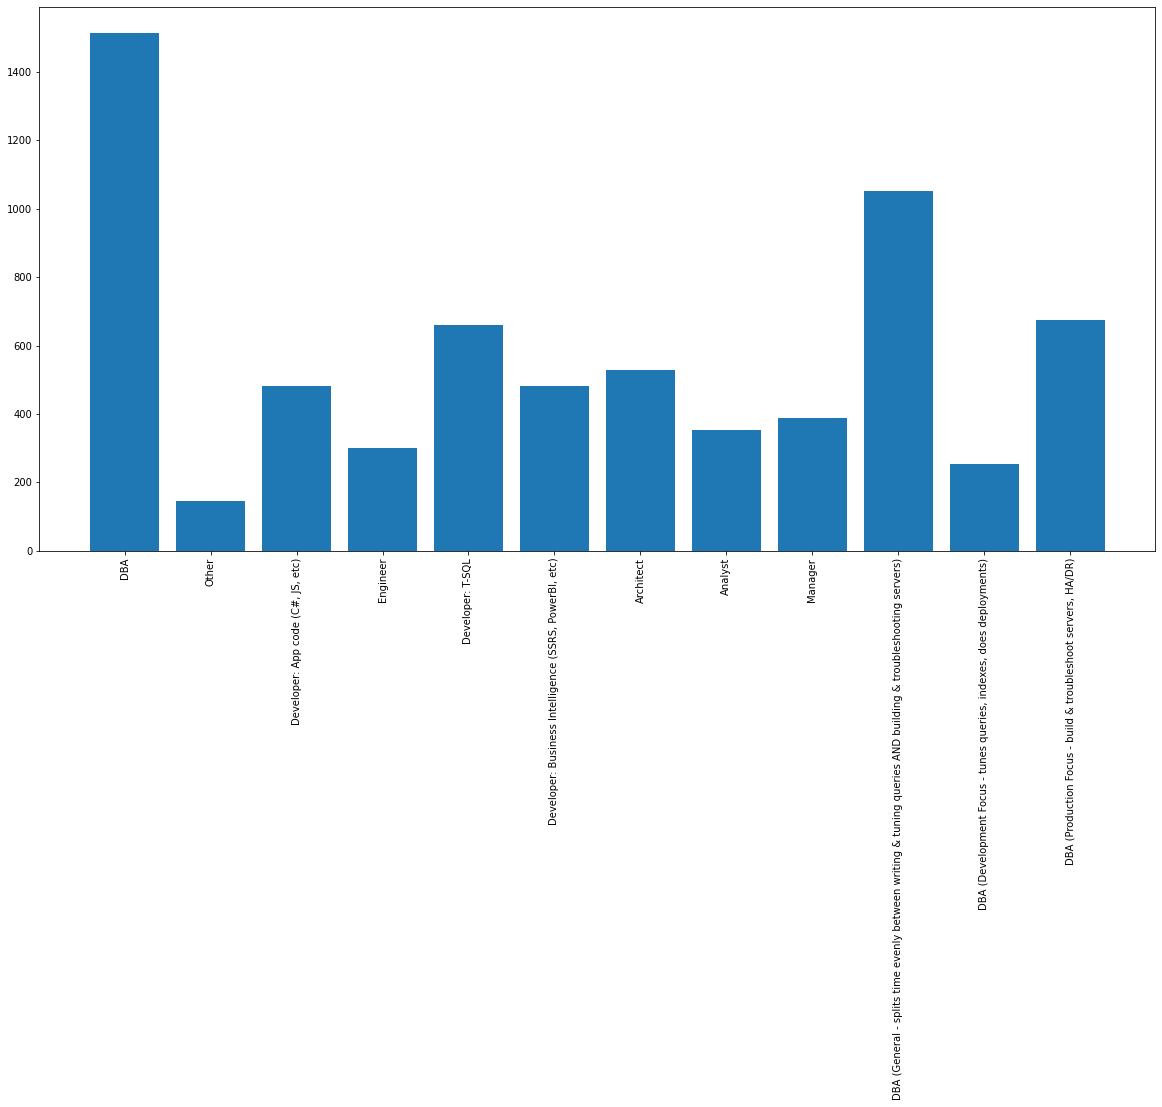

In [284]:
job_pairs = Counter(df.JobTitle)
L = job_pairs.copy() 
for key, value in L.items(): 
  if value < 100 : 
    job_pairs['Other'] += value
    job_pairs.pop(key)
VAL = pd.DataFrame.from_dict(job_pairs, orient='index')
VAL.columns = ["value"]
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(VAL.index, height= VAL.value)
plt.xticks(rotation= 90)
plt.show()

In [285]:
salary_JobTitle = df[['SalaryUSD','JobTitle']].groupby(['JobTitle']).mean().sort_values(by = 'SalaryUSD', ascending = False)
salary_JobTitle

,SalaryUSD
JobTitle,
Sales,300000.000000
Principal database engineer,175000.000000
Consultant,160000.000000
Sr Consultant,122000.000000
"DevOps, Sr Software Engineer DBA",120000.000000
Architect,119209.142315
Manager,115182.424165
Data Scientist,111428.321429
Engineer,99875.755853


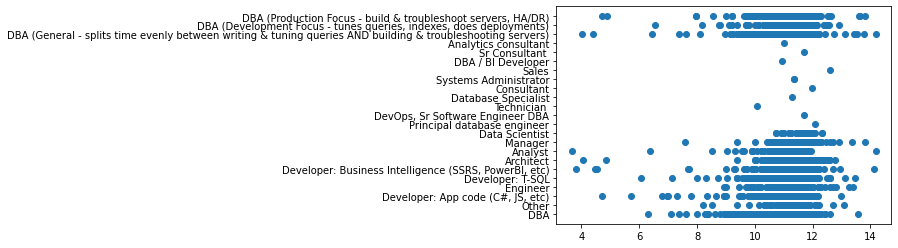

In [286]:
plt.plot(np.log(df["SalaryUSD"]),df["JobTitle"],'o')
plt.show()

In [287]:
df.loc[:,'OtherJobDuties'] = df.loc[:,'OtherJobDuties'].fillna('Unkown')
salary_OtherJobDuties = df[['SalaryUSD','OtherJobDuties']].groupby(['OtherJobDuties']).mean().sort_values(by = 'SalaryUSD',ascending = False)
salary_OtherJobDuties

,SalaryUSD
OtherJobDuties,
"Architect, Data Scientist, Developer: App code (C#, JS, etc), Developer: T-SQL, Manager",1450000.0
"Architect, Data Scientist, DBA (Development Focus - tunes queries, indexes, does deployments), DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers), Developer: App code (C#, JS, etc), Developer: Business Intelligence (SSRS, PowerBI, etc), Developer: T-SQL, Engineer, Manager",1000000.0
"Analyst, Architect, Data Scientist, Manager",704000.0
"Data Scientist, DBA (Development Focus - tunes queries, indexes, does deployments), DBA (Production Focus - build & troubleshoot servers, HA/DR), Developer: Business Intelligence (SSRS, PowerBI, etc), Developer: T-SQL, Manager",500000.0
"Analyst, Architect, Developer: App code (C#, JS, etc), Manager",500000.0
...,...
"DBA (Development Focus - tunes queries, indexes, does deployments), DBA (Production Focus - build & troubleshoot servers, HA/DR), Developer: Business Intelligence (SSRS, PowerBI, etc), Developer: T-SQL, Engineer",15000.0
"DBA (Development Focus - tunes queries, indexes, does deployments), DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers), Developer: Business Intelligence (SSRS, PowerBI, etc), Developer: T-SQL, Engineer",14139.0
"DBA (Development Focus - tunes queries, indexes, does deployments), DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers), Engineer",130.0


In [288]:
def get_elements(key): 
  L = key.split(",")
  Result = []
  i = 0 
  while i < len(L):
    word = L[i]
    if word.find("(") != -1: 
      while word.find(")") == -1 : 
        i += 1 
        word = word +","+ L[i]
    i += 1
    Result.append(word) 
  return Result

def get_job_count(X): 
  job_duties_pairs = Counter(X.OtherJobDuties)
  job_duty_paris = {}
  for key, _ in job_duties_pairs.items():
    words = get_elements(key)

In [289]:
job_duties_counter = Counter(df.OtherJobDuties)
job_duties_pairs = {}

for key, value in job_duties_counter.items():
  duties = get_elements(key)
  for dutie in duties:
    if dutie not in job_duties_pairs.keys(): 
      job_duties_pairs[dutie] = [value]
    else:
      job_duties_pairs[dutie][0] += value 

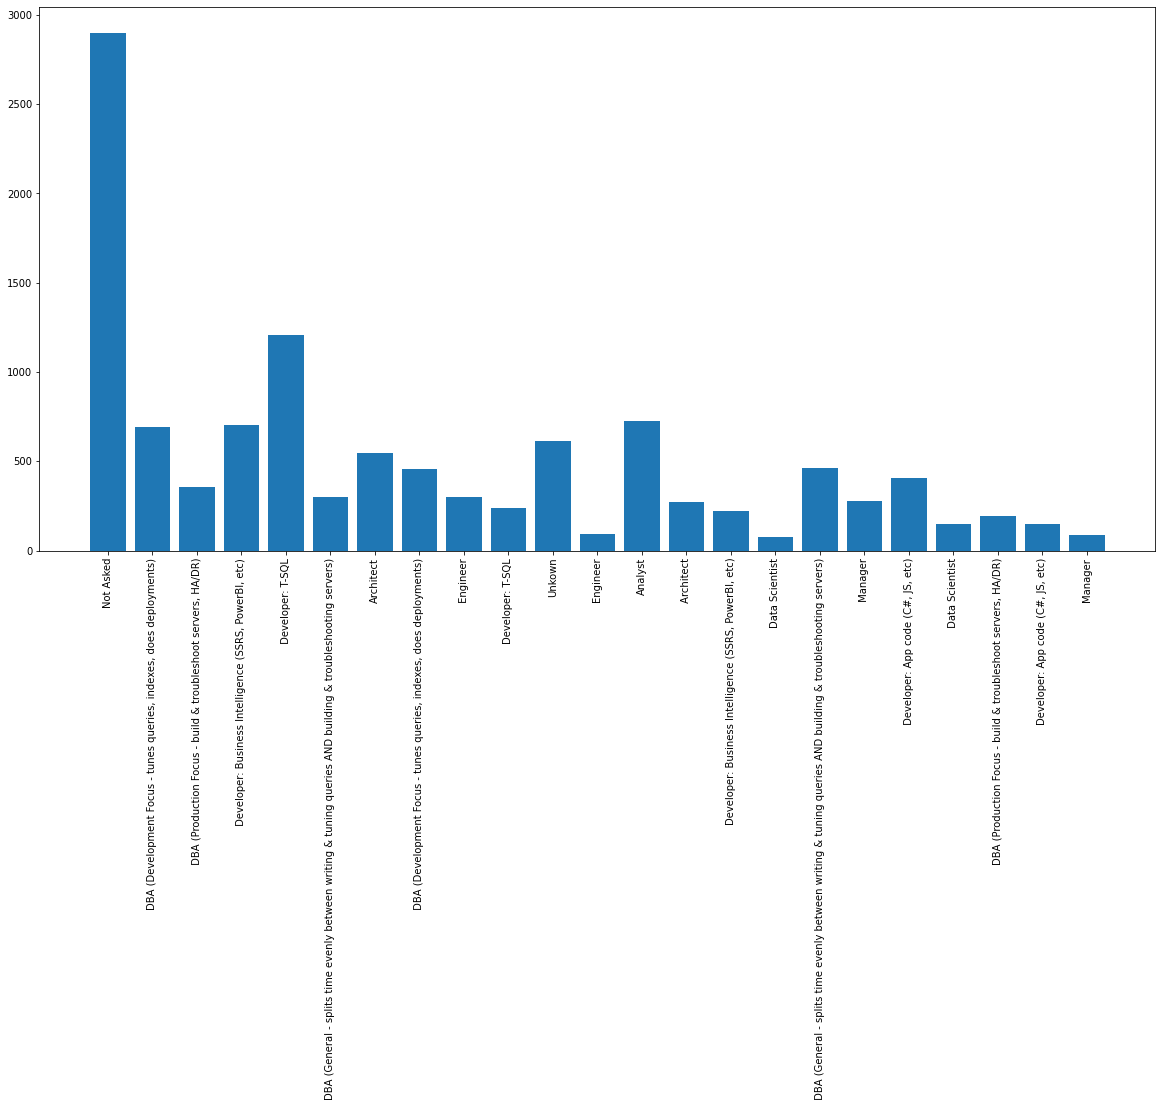

In [290]:
VAL = pd.DataFrame.from_dict(job_duties_pairs, orient='index')
VAL.columns = ["value"]
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(VAL.index, height= VAL.value)
plt.xticks(rotation= 90)
plt.show()

In [291]:
df.loc[:,'KindsOfTasksPerformed'] = df.loc[:,'KindsOfTasksPerformed'].fillna('Unkown')
salary_KindsOfTasksPerformed = df[['SalaryUSD','KindsOfTasksPerformed']].groupby(['KindsOfTasksPerformed']).mean().sort_values(by = 'SalaryUSD',ascending = False)
salary_KindsOfTasksPerformed

,SalaryUSD
KindsOfTasksPerformed,
"Manual tasks, On-call 24/7/365, Projects, Training/teaching",424000.000000
"Manual tasks, Meetings & management, R&D",402500.000000
"Build scripts & automation tools, Meetings & management, On-call 24/7/365, R&D, Training/teaching",184333.333333
"Manual tasks, Meetings & management, On-call as part of a rotation, Projects, R&D, Training/teaching",158071.428571
"Projects, Training/teaching",155966.666667
...,...
"Build scripts & automation tools, R&D, Training/teaching",35000.000000
"Build scripts & automation tools, Meetings & management, On-call as part of a rotation, On-call 24/7/365",20750.000000
"Build scripts & automation tools, Meetings & management, On-call as part of a rotation, On-call 24/7/365, Projects, R&D",15600.000000


In [292]:
taks_perf_counter = Counter(df.KindsOfTasksPerformed)
taks_perf_pairs = {}

for key, value in taks_perf_counter.items():
  tasks = get_elements(key)
  for task in tasks:
    if task not in taks_perf_pairs.keys(): 
      taks_perf_pairs[task] = [value]
    else:
      taks_perf_pairs[task][0] += value 

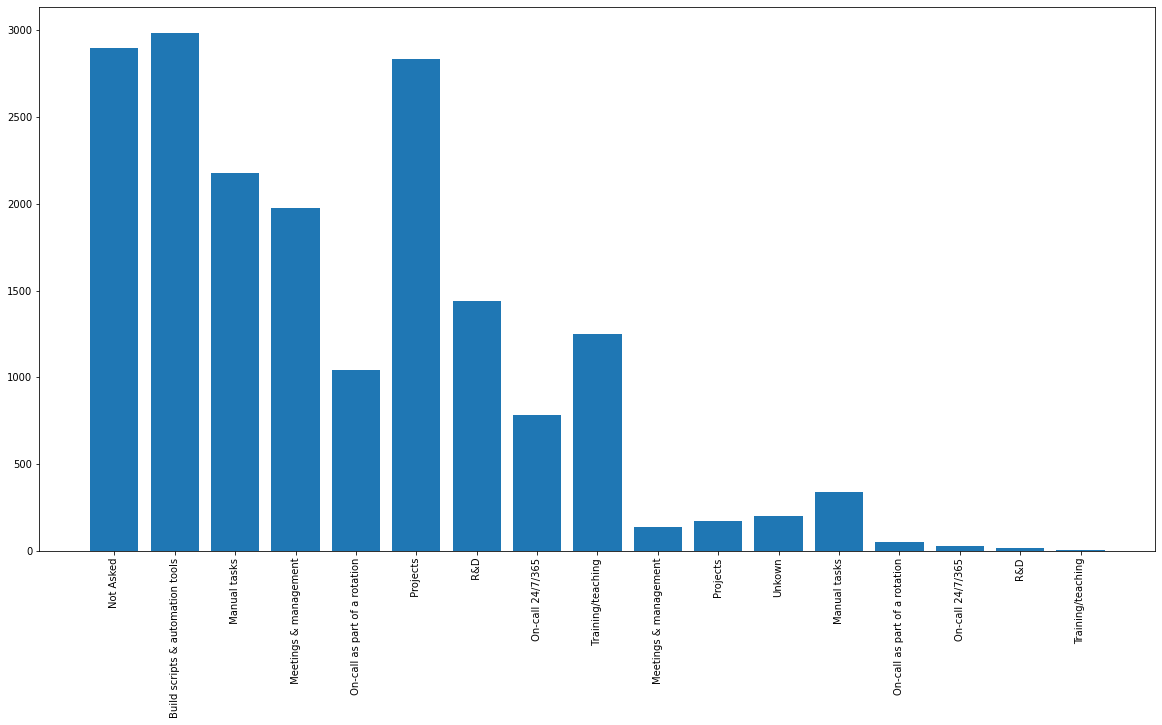

In [293]:
VAL = pd.DataFrame.from_dict(taks_perf_pairs, orient='index')
VAL.columns = ["value"]
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(VAL.index, height= VAL.value)
plt.xticks(rotation= 90)
plt.show()

In [294]:
salary_CareerPlansThisYear = df[['SalaryUSD','CareerPlansThisYear']].groupby(['CareerPlansThisYear']).mean().sort_values(by = 'SalaryUSD',ascending = False)
salary_CareerPlansThisYear

,SalaryUSD
CareerPlansThisYear,
"Stay with the same employer, same role",96937.772605
"Stay with the same employer, but change roles",93489.900536
Change both employers and roles,91391.738493
Not Asked,90716.307453
Prefer not to say,90198.612495
"Stay with the same role, but change employers",87102.390258


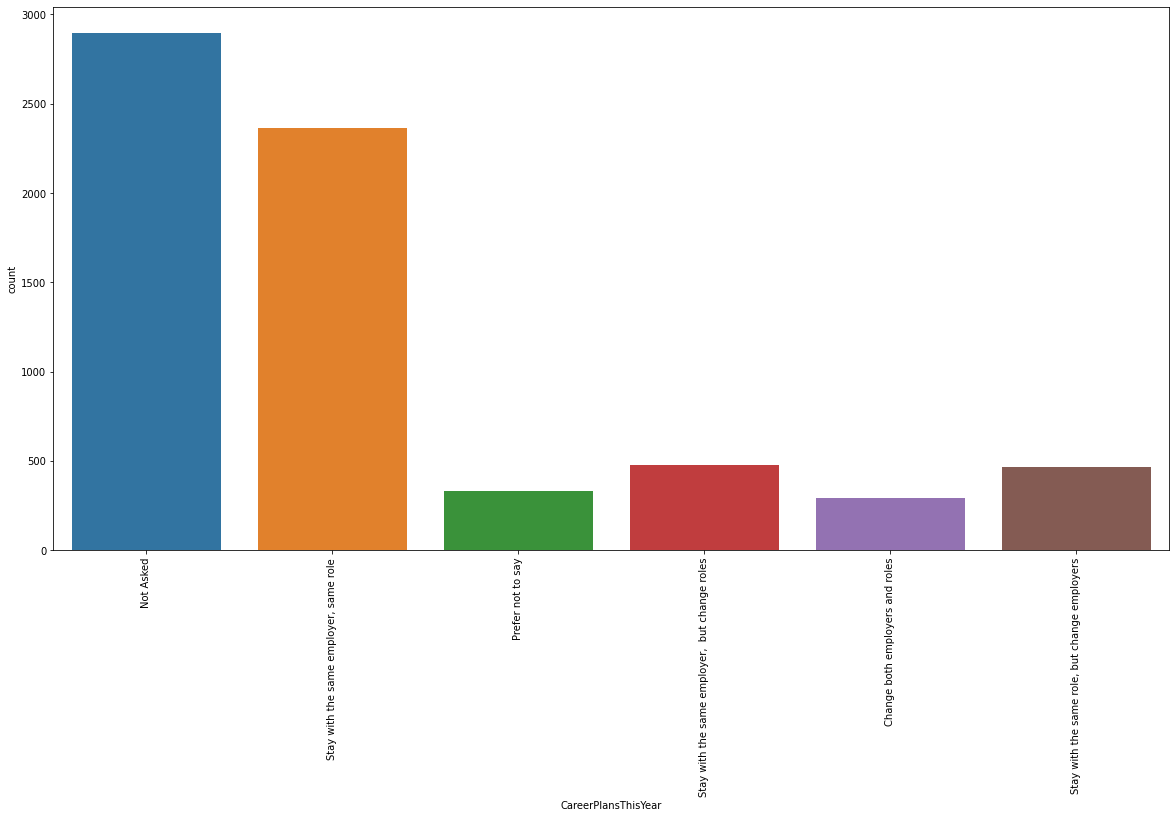

In [295]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot( x = df["CareerPlansThisYear"])
plt.xticks(rotation= 90)
plt.show()

# <a style="color:#920037">Submission
## Data Preprocessing 


Preprocessing the Gender columns requires dropping some lines, unfortunately this means we wont be able to plug it into a scikit-learn pipeline as it does not support dropping lines from the data frame 

In [296]:
df = pd.read_excel('https://query.data.world/s/yg4pp7vm5dhoj6pj4xjm43gcg73ujq',header=3)
df.drop(columns=['Timestamp','PostalCode', 'Counter', 'CompanyEmployeesOverall', 'PopulationOfLargestCityWithin20Miles'], inplace=True)
df['SalaryUSD'] = list(map(float, [str(ch).replace(" ", "").replace(",", ".") for ch in list(df.SalaryUSD)]))

In [297]:
Counter(df['Gender'])

Counter({'Alien': 1,
         'Any human one': 1,
         'Apache Helicopter': 1,
         'Attack Helicopter': 2,
         'Attack Helicopter (M)': 1,
         'Attack Helicopter. (serious dude, gender questions?)': 1,
         'Attackhelicopter with rabbitears and afro-icelandic teeth': 1,
         'Cyborg': 1,
         'Dragon': 1,
         'Female': 395,
         'Grayson Perry': 1,
         'Male': 3530,
         'Meat Popsicle ': 1,
         'Muppet': 1,
         'Non-binary/third gender': 8,
         'Not Asked': 2898,
         'Pastafarian': 1,
         'Prefer not to say': 42,
         'Reptilian': 1,
         'There are only two genders for people, either male or female. I am a male.': 1,
         'This question is inappropriate. ': 1,
         'Vulcan': 1,
         'confused': 1,
         'toad frog': 1})

In [298]:
def Get_Genders(X_df):
  res = X_df[(X_df.Gender == "Male") | (X_df.Gender == "Female") | (X_df.Gender == 'Non-binary/third gender') | (X_df.Gender == 'Not Asked')] 

  res = res.replace({'Gender':{'Not Asked' : 'Other',
                      'Non-binary/third gender':'Other'}})
  res['Gender'] = OrdinalEncoder().fit_transform(res[["Gender"]])
  return res
df = Get_Genders(df)

The rest of the columns can be preprocessed using columns transformers 

In [299]:
def HMC_transformer(X_df):
  res = X_df.replace({'HowManyCompanies':{'Not Asked' : 0 ,
                      "1 (this is the only company where I've had this kind of position)":1,
                      '2 (I worked at another similar position elsewhere before this one)':2,
                      '6 or more':6}})
  res['HowManyCompanies'] = res['HowManyCompanies'].fillna(0)
  res['HowManyCompanies'] = OrdinalEncoder().fit_transform(res[["HowManyCompanies"]])
  return res
def OPOYT_transformer(X_df):
  res = X_df.replace({"OtherPeopleOnYourTeam":{'None': 0 ,'More than 5':6} })
  res['OtherPeopleOnYourTeam'] = res['OtherPeopleOnYourTeam'].fillna(0)
  res['OtherPeopleOnYourTeam'] = OrdinalEncoder().fit_transform(res[["OtherPeopleOnYourTeam"]])
  return res
def Country_transformer(X_df):
  res = X_df
  res['Country'] = X_df['Country'].fillna('Unknown')
  res['Country'] = OrdinalEncoder().fit_transform(res[["Country"]])
  return res
transformer_HMC = FunctionTransformer(
    lambda X_df: HMC_transformer(X_df)
)
transformer_OPOYT = FunctionTransformer(
    lambda X_df: OPOYT_transformer(X_df)
)
transformer_country = FunctionTransformer(
    lambda X_df: Country_transformer(X_df)
)
transformer_b = make_column_transformer((transformer_HMC,['HowManyCompanies']),(transformer_OPOYT,['OtherPeopleOnYourTeam']),(transformer_country,['Country']))
def transformer_1(df,threshold=150):
  se = Count_("OtherDatabases")
  most_used_db = []
  for i,j in se.items():
    if j>threshold:
      if type(i)==str:
        most_used_db.append(i)
  new_cols={}
  for i in most_used_db:
    new_cols[i]=np.zeros(df.shape[0])

  for i,line in enumerate(df['OtherDatabases']):
    if type(line) is str :
      databases = line.split(', ')
      for db in databases:
        if db in new_cols:
          new_cols[db][i]=1

  for i in most_used_db:
    df[i] = new_cols[i]

  df['OtherDatabases'] = df['OtherDatabases'].str.split(', ').str.len()
  df['OtherDatabases'].fillna(0, inplace = True)
  df["PrimaryDatabase"] = df["PrimaryDatabase"].astype('category')
  df["PrimaryDatabase"] = df["PrimaryDatabase"].cat.codes
  return df

  
transformer_K = FunctionTransformer(
    lambda X_df: transformer_1(X_df)
)
transformer_KS = make_column_transformer((transformer_K,['OtherDatabases','PrimaryDatabase']))
def encode_feature(df,feature):
  df[feature] = df[feature].fillna("Unkown")
  ord_enc = OrdinalEncoder()
  return ord_enc.fit_transform(df[[feature]]).reshape((len(df[[feature]]),1))

def standard_scale(df,feature):
  res = df[[feature]].to_numpy().reshape((len(df[[feature]]),1))
  return (res - np.mean(res))/np.std(res)

cols = ["Education",
        "HoursWorkedPerWeek",
        'Certifications',
        'EducationIsComputerRelated']

transformer_Education = FunctionTransformer(lambda df: encode_feature(df,'Education'))
transformer_Certifications = FunctionTransformer(lambda df: encode_feature(df,'Certifications'))
transformer_EducationIsComputerRelated = FunctionTransformer(lambda df: encode_feature(df,'EducationIsComputerRelated'))
transformer_HoursWorkedPerWeek = FunctionTransformer(lambda df: standard_scale(df,'HoursWorkedPerWeek'))

transformer_MK = make_column_transformer(
    (transformer_Education,['Education']),
    (transformer_HoursWorkedPerWeek,['HoursWorkedPerWeek']),
    (transformer_Certifications,['Certifications']),
    (transformer_EducationIsComputerRelated,['EducationIsComputerRelated']), 
    ('passthrough', cols)
)
jt = Counter(df1.JobTitle)
job_dict = {}
for job, count in jt.items():
  if count < 20 :
    job_dict[job] = "Other"
  else :
    job_dict[job] = job

sector_dict={'Education (K-12, college, university)': 0,
 'Federal government': 1,
 'Local government': 2,
 'Non-profit': 3,
 'Private business': 4,
 'State/province government': 5,
 'Student': 0}
 ##############

def JobTitle(df,job_dict):
  jobs = df.JobTitle.apply(lambda x:job_dict[x]).to_numpy()
  return (jobs.reshape((len(jobs),1)))

def sector(df,sector_dict):
  sectors =  df.EmploymentSector.apply(lambda x:sector_dict[x]).to_numpy()
  return (sectors.reshape((len(sectors),1)))



transformer_JobTitle = FunctionTransformer(lambda df: JobTitle(df,job_dict))
transformer_sector = FunctionTransformer(lambda df: sector(df,sector_dict))

# categorical columns with ordinal encoding
cat_cols = ["ManageStaff", "EmploymentStatus"]
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='constant'),
    OrdinalEncoder(),
)

transformer_nk = make_column_transformer(
    (cat_pipeline, cat_cols),
    (transformer_JobTitle,["JobTitle"]),
    (transformer_sector,["EmploymentSector"])
)

def get_elements(key): 
  L = key.split(",")
  Result = []
  i = 0 
  while i < len(L):
    word = L[i]
    if word.find("(") != -1: 
      while word.find(")") == -1 : 
        i += 1 
        word = word +","+ L[i]
    i += 1
    Result.append(word) 
  return Result

def get_elts_count(X, col): 
  elts_counter = Counter(X[col])
  elts_pairs = {}
  for key, value in elts_counter.items():
    if type(key) != str:
      continue
    elts = get_elements(key)
    for elt in elts:
      if elt not in elts_pairs.keys(): 
        elts_pairs[elt] = value
      else:
        elts_pairs[elt] += value 
  return elts_pairs

def get_dummy_jobs(X_df, num): # Here X_df is composed of a single column
  feature_array = np.zeros((len(X_df.index), num))
  col_name = X_df.columns[0]
  elts_pairs  = get_elts_count(X_df, col_name)
  elts_pairs = [(key,value) for key, value  in elts_pairs.items()]
  elts_pairs =  sorted(elts_pairs, key=lambda tup: tup[1], reverse= True)
  elts_kept = [pair[0]  for pair in elts_pairs[:num] ]
  X_df = X_df[col_name]
  indexes = list(X_df.index.values)
 
  for p in range(len(X_df)):
    i = indexes[p]
    if (type(X_df[i]) != str):
      for  j in range(len(elts_kept)):
        feature_array[p][j] = np.nan
      continue
    elts = get_elements(X_df[i])
    for  j in range(len(elts_kept)): 
      if elts_kept[j] in elts : 
        feature_array[p][j] = 1 
  return feature_array
transformer_dummy_jobs = FunctionTransformer(
    lambda X_df: get_dummy_jobs(X_df, 1)
)
def get_top_jobs(X_df, num): # Here X_df is composed of a single column
  feature_array = np.zeros((len(X_df), num))
  col_name = X_df.columns[0]
  elts_pairs = Counter(X_df[col_name])
  elts_pairs = [(key,value) for key, value  in elts_pairs.items()]
  elts_pairs =  sorted(elts_pairs, key=lambda tup: tup[1], reverse= True)
  elts_kept = [pair[0]  for pair in elts_pairs[:num - 1] ]
  if 'Other' in elts_kept: 
    elts_kept.append(elts_pairs[num][0])
  else : 
    elts_kept.append('Other')
  Other_index = elts_kept.index('Other')
  X_df = X_df[col_name]
  indexes = list(X_df.index.values)
 
  for p in range(len(X_df)):
    i = indexes[p]
    if (type(X_df[i]) != str):
      for  j in range(len(elts_kept)):
        feature_array[p][j] = np.nan
      continue
    elt = X_df[i]
    if  elt in elts_kept:
      for j in range(num): 
        if elt == elts_kept[j]: 
          feature_array[p][j] = 1
          break
    else: 
      feature_array[p][num-1] = 1
  return feature_array

transformer_JobTitle = FunctionTransformer(
    lambda X_df: get_top_jobs(X_df, 4)
)

job_transformer = Pipeline(steps=[
    ('transform', transformer_dummy_jobs),
    ('imputer', SimpleImputer(strategy= 'most_frequent'))])


jobTitle_transfomer = Pipeline(steps=[
    ('transform', transformer_JobTitle),
    ('imputer', SimpleImputer(strategy= 'most_frequent'))])
carreer_transformer = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder()),
    ('imputer', SimpleImputer(strategy= 'most_frequent')),          
])
LAJ_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy= 'most_frequent')),          
])
othercols = ['Survey Year',
 'YearsWithThisDatabase',
 'YearsWithThisTypeOfJob',
 'DatabaseServers',
  'Gender']
preprocessor = ColumnTransformer(
    transformers=[
        ('0', job_transformer, ['OtherJobDuties']),
        ('1', job_transformer, ['KindsOfTasksPerformed']),
        ('2', jobTitle_transfomer, ['JobTitle']),
        ('3', carreer_transformer, ['CareerPlansThisYear']),
        ('4', transformer_HMC, ['HowManyCompanies']),
        ('5', transformer_OPOYT, ['OtherPeopleOnYourTeam']),
        ('6', transformer_country, ['Country']),
        ('7',transformer_Education,['Education']),
        ('8',transformer_HoursWorkedPerWeek,['HoursWorkedPerWeek']),
        ('9',transformer_Certifications,['Certifications']),
        ('10',transformer_EducationIsComputerRelated,['EducationIsComputerRelated']),
        ('11',cat_pipeline, cat_cols),
        ('12',transformer_sector,["EmploymentSector"]),
        ('13',transformer_K,['OtherDatabases','PrimaryDatabase']),
        ('15',LAJ_transformer,['LookingForAnotherJob']),
        ('14','passthrough',othercols)

    ])



# <a style="color:#920037"> BASELINE MODEL  </a>
## <a style="color:#920037"> Random Forest Regressor MODEL  </a>

In [301]:
from sklearn.model_selection import train_test_split 
X = preprocessor.fit_transform(df.drop('SalaryUSD',axis=1))
y = df['SalaryUSD']
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.33, random_state=42)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

We will try to predict the log of the salaries to compensate for the extreme values 

In [302]:
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)
rgr = RandomForestRegressor()
rgr.fit(X_train,y_train)
y_pred = rgr.predict(X_test)
rms = mean_squared_error(y_test,y_pred, squared=False)
print('RMSE = ',rms)

RMSE =  0.5692453973435759


## <a style="color:#920037"> Neural Network MODEL  </a>

In [303]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               4608      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 169,473
Trainable params: 169,473
Non-trainable params: 0
_________________________________________________________________


In [304]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/100
115/115 [==============================] - 1s 5ms/step - loss: 65.0793 - mean_squared_error: 65.0793 - val_loss: 7844.2974 - val_mean_squared_error: 7844.2974

Epoch 00001: val_loss improved from inf to 7844.29736, saving model to Weights-001--7844.29736.hdf5
Epoch 2/100
115/115 [==============================] - 0s 4ms/step - loss: 53.7615 - mean_squared_error: 53.7615 - val_loss: 5666.1753 - val_mean_squared_error: 5666.1753

Epoch 00002: val_loss improved from 7844.29736 to 5666.17529, saving model to Weights-002--5666.17529.hdf5
Epoch 3/100
115/115 [==============================] - 0s 4ms/step - loss: 23.6719 - mean_squared_error: 23.6719 - val_loss: 124.3545 - val_mean_squared_error: 124.3545

Epoch 00003: val_loss improved from 5666.17529 to 124.35452, saving model to Weights-003--124.35452.hdf5
Epoch 4/100
115/115 [==============================] - 0s 4ms/step - loss: 18.8415 - mean_squared_error: 18.8415 - val_loss: 108.8124 - val_mean_squared_error: 108.8124

Epoc

In [311]:
y_pred = NN_model.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE = ',rms)

RMSE =  0.6809236777280843
